In [1]:
! ls ../input/tokyo6

tokyo_jpx-0.0.32-py3-none-any.whl


In [2]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [3]:
!pip install tokyo-jpx --upgrade --no-index --find-links=file:///kaggle/input/tokyo6/ 


Looking in links: file:///kaggle/input/tokyo6/
Processing /kaggle/input/tokyo6/tokyo_jpx-0.0.32-py3-none-any.whl


In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
# pl.utilities.seed.seed_everything(seed=42)
import numpy as np
import pandas as pd

from preprocessing.preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader, 
    ts_split,
    cont_cat_split,
    dataloader_by_stock,
    get_data
) 
from models.dl import NeuralNetwork
from train.trainer import Trainer, plot_loss
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

from preprocessing.preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader, 
    get_predict_loader,
    ts_split,
    cont_cat_split,
    dataloader_by_stock,
    get_data,
    dataloader_test_by_stock
)
from metrics.metrics import calc_spread_return_sharpe
from predictions.predict import run_pred_step

In [5]:
ROOT_PATH = "/kaggle/input/jpx-tokyo-stock-exchange-prediction/"
FOLDER = "train_files"
train_df = get_data(folder=FOLDER, root_path=ROOT_PATH)
UNITS = 128
BLOCKS = 4
STACKS = 4

BATCH_SIZE = 512
weight_decay = 0.1
EPOCHS = 1

"""
SUBTRACT:
*) 3 FROM CONTINUOUS COLS BECAUSE OF POOLING
*) 1 FROM CAT_FEATURES TO MAKE MATRICES MATCH AFTER TORCH.CAT
"""
CONT_COLS=[
    'Close', 
    'Volume',
#     'Open', 
#     'High', 
#     'Low', 
    'MarketCapitalization',         
           # 'NetSales', 'EquityToAssetRatio', 'TotalAssets', 'Profit', 
           # 'OperatingProfit', 'EarningsPerShare', 'Equity', 
           # 'BookValuePerShare', 'ResultDividendPerShare1stQuarter', 
           # 'ResultDividendPerShare2ndQuarter', 'ResultDividendPerShare3rdQuarter',
           # 'ResultDividendPerShareFiscalYearEnd', 'ResultDividendPerShareAnnual'
          ]
TS_IN_FEATURES = len(CONT_COLS) - 2
CAT_FEATURES = 4 + 4 - 1 # TEXT_COLS = ['Section/Products', '33SectorName', '17SectorName', 'Universe0']
print('CAT_FEATURES:', CAT_FEATURES)
EMBEDDING_DIM = 100
NO_EMBEDDING = 2000 #2 * len(df_train_cat)

train_df.head(10):
            Section/Products  33SectorName  17SectorName  Universe0  \
Date                                                                  
2017-01-04                 0             6             8          0   
2017-01-05                 0             6             8          0   
2017-01-06                 0             6             8          0   
2017-01-10                 0             6             8          0   
2017-01-11                 0             6             8          0   
2017-01-12                 0             6             8          0   
2017-01-13                 0             6             8          0   
2017-01-16                 0             6             8          0   
2017-01-17                 0             6             8          0   
2017-01-18                 0             6             8          0   

            MarketCapitalization  SecuritiesCode          RowId    Open  \
Date                                                 

# Config and create model

In [6]:


# Create model
def create_model():
    model = None
    model = NeuralNetwork(
        in_features=TS_IN_FEATURES, 
        units=UNITS,
        out_features=1, 
        categorical_dim=CAT_FEATURES,
        no_embedding=NO_EMBEDDING, 
        emb_dim=EMBEDDING_DIM,
        n_blocks=BLOCKS,
        n_stacks=STACKS,
        dropout=0.1,
        pooling_sizes=3
    )
    return model

# Train a random choice of stocks

In [7]:
%%time
stocks = train_df['SecuritiesCode'].unique()
count = 0

scaler_dict = {}

model = create_model()

trainer = Trainer(
    model, 
    optimizer_name='rmsprop', 
    lr=1.3333e-5, 
    weight_decay=weight_decay
)

torch.autograd.set_detect_anomaly(True)

train_loss_list = []
train_mae_list = []
valid_loss_list = []
valid_mae_list = []

"""
SHUFFLE STOCKS WHEN TRAINING
"""
np.random.seed(0)
"""
DO RANDOM CHOICE OF STOCKS.
Run only once
"""
np.random.shuffle(stocks) # SHUFFLE STOCKS IN PLACE

TRAIN_ON_STOCKS = stocks[: 10]
print(stocks)
for no_stock, stock in enumerate(stocks):
    try:
        train_loader, val_dataloader = None, None
        print(f'Stock-iteratation: {no_stock}')
        print(f'Start training for stock: {stock}')
        train_dataloader, val_dataloader, scaler = dataloader_by_stock(
            train_df, 
            stock, 
            batch_size=BATCH_SIZE, 
            continous_cols=CONT_COLS,
            return_scaler=True,
            transform=MaxAbsScaler         
        )
        scaler_dict[stock] = scaler

        if stock in TRAIN_ON_STOCKS:
            train_loss, train_mae, val_loss, val_mae = trainer.fit_epochs(
                train_dataloader, 
                val_dataloader, 
                use_cyclic_lr=True, 
                x_cat=True, 
                epochs=EPOCHS
            )
            train_loss_list.extend(train_loss)
            train_mae_list.extend(train_mae)
            valid_loss_list.extend(val_loss)
            valid_mae_list.extend(val_mae)
        
        print('#' * 20)
        print()
#         count += 1
    except Exception as e:
        print(f'Training loop: {e}')
    
# with open('scaler_dict.pkl', 'wb') as f:
#     pickle.dump(scaler_dict, f)

Using cuda-device
[3457 6779 6586 ... 8355 4100 4550]
Stock-iteratation: 0
Start training for stock: 3457
Training loop: Expected 3-dimensional tensor, but got 2-dimensional tensor for argument #1 'self' (while checking arguments for max_pool1d)
Stock-iteratation: 1
Start training for stock: 6779
Training loop: Expected 3-dimensional tensor, but got 2-dimensional tensor for argument #1 'self' (while checking arguments for max_pool1d)
Stock-iteratation: 2
Start training for stock: 6586
Training loop: Expected 3-dimensional tensor, but got 2-dimensional tensor for argument #1 'self' (while checking arguments for max_pool1d)
Stock-iteratation: 3
Start training for stock: 4676
Training loop: Expected 3-dimensional tensor, but got 2-dimensional tensor for argument #1 'self' (while checking arguments for max_pool1d)
Stock-iteratation: 4
Start training for stock: 8909
Training loop: Expected 3-dimensional tensor, but got 2-dimensional tensor for argument #1 'self' (while checking arguments fo

# Save model

In [8]:
torch.save(model.state_dict(), '/kaggle/working/trained_model.pt')


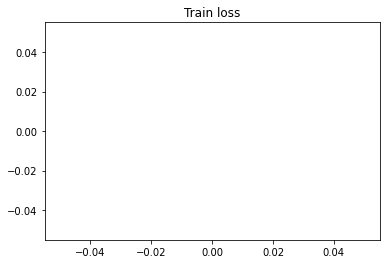

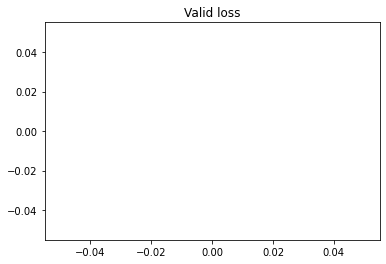

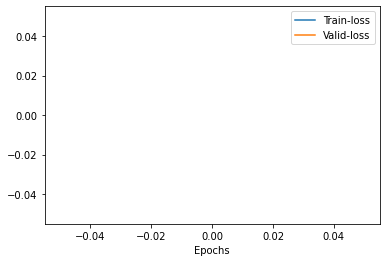

In [9]:
plt.plot(train_loss_list)
plt.title('Train loss');
plt.show()

plt.plot(valid_loss_list)
plt.title('Valid loss')
plt.show()

plot_loss(train_loss_list, valid_loss_list, 'Train-loss', 'Valid-loss')

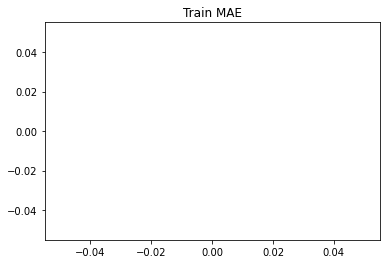

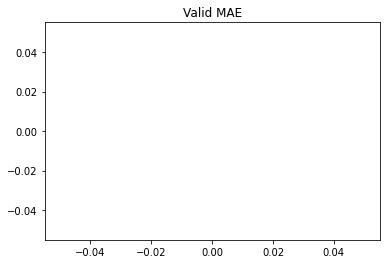

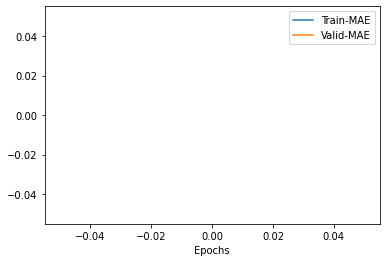

In [10]:
plt.plot(train_mae_list)
plt.title('Train MAE');
plt.show()

plt.plot(valid_mae_list)
plt.title('Valid MAE')
plt.show()

plot_loss(train_mae_list, valid_mae_list, 'Train-MAE', 'Valid-MAE')

# Make predictions and Submit Results 
* TODO: train_dataloader should save all scalers during training even though we not train on all stocks. 

## Rank stocks from model

In [11]:
# import jpx_tokyo_market_prediction
# env = jpx_tokyo_market_prediction.make_env()
# iter_test = env.iter_test()

In [12]:
# Remove scalers
trained_model = NeuralNetwork(
    in_features=TS_IN_FEATURES, 
    units=UNITS,
    out_features=1, 
    categorical_dim=CAT_FEATURES,
    no_embedding=NO_EMBEDDING, 
    emb_dim=EMBEDDING_DIM,
    n_blocks=BLOCKS,
    n_stacks=STACKS,
    dropout=0.1,
    pooling_sizes=3
)

trained_model.load_state_dict(torch.load('/kaggle/working/trained_model.pt'))
trained_model.eval()

counter = 0
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    sample_prediction_df = pd.DataFrame()
    date = np.unique(pd.to_datetime(prices['Date']).dt.strftime('%Y-%m-%d'))[-1]
#     prices['Date'] = pd.to_datetime(prices['Date']).dt.strftime('%Y%m%d').astype(int)
    df = get_data(root_path=ROOT_PATH, prices=prices)
    pred_df = pd.DataFrame()

    for count, stock in enumerate(stocks):
        try:
            print('Iteretation:', count)
            scaler = scaler_dict[stock]
            test_dataloader, idx = dataloader_test_by_stock(
                df, 
                stock, 
                transformer=scaler,
                batch_size=BATCH_SIZE, 
                continous_cols=CONT_COLS,
                target_col=None
            )
            pred_list = run_pred_step(test_dataloader, trained_model, x_cat=True)
            df_pred = pd.DataFrame({'SecuritiesCode': stock, 'Target': pred_list}, index=[date]) # maybe index should only be idx
            df_pred.index.rename('Date', inplace=True)
            pred_df = pd.concat([pred_df, df_pred]) 
        except Exception as e:
            print(f'Exception {e}')
        
    sample_prediction_df = sample_prediction.copy()
    pred_df['Rank'] = np.int64(pred_df['Target'].rank(method='first',ascending=False).values - 1)
    feature_map = pred_df.set_index('SecuritiesCode')['Rank'].to_dict()
    sample_prediction_df['Rank'] = sample_prediction_df['SecuritiesCode'].map(feature_map)
    sample_prediction_df.Rank = np.int64(sample_prediction_df.Rank)

    assert sample_prediction_df.Rank.nunique() == 2000
    assert sample_prediction_df.Rank.notna().all()
    assert sample_prediction_df.Rank.min() == 0
    assert sample_prediction_df.Rank.max() == len(sample_prediction_df.Rank) - 1
    print(sample_prediction_df)

    sample_prediction_df.reset_index(inplace=True)

    sample_prediction_df = sample_prediction_df[['Date', 'SecuritiesCode', 'Rank']]
    env.predict(sample_prediction_df)  


This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
train_df.head(10):
            Section/Products  33SectorName  17SectorName  Universe0  \
Date                                                                  
2021-12-06                 0             6             8          0   
2021-12-06                 0             6             8          0   
2021-12-06                 0             6             8          0   
2021-12-06                 0             6             8          0   
2021-12-06                 0             6             8          0   
2021-12-06                 0             6             8          0   
2021-12-06                 0             6             8          0   
2021-12-06                 2             6             8          0   
2021-12-06                 2             3             3          0   
2021-12-06                 0             3             3          0   

   

In [13]:
len(sample_prediction_df.Rank) - 1, sample_prediction_df.Rank.max(), sample_prediction_df.Rank.min()

(1999, 1999, 0)

In [14]:
len(sample_prediction_df.Rank) - 1, sample_prediction_df.Rank.max() 

(1999, 1999)

In [15]:
sample_prediction_df.Rank.nunique(), sample_prediction_df.Rank.unique() ,sample_prediction_df.Rank.min(), sample_prediction_df.Rank.max()

(2000, array([ 649,  132,  971, ...,  682, 1263, 1278]), 0, 1999)